In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load and preprocess CIFAR-10 dataset
def preprocess_data():
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return dataloader

dataloader = preprocess_data()

Files already downloaded and verified


In [2]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, text_dim):  # Corrected to __init__
        super(Generator, self).__init__()
        input_dim = noise_dim + text_dim
        self.main = nn.Sequential(
            nn.Linear(input_dim, 4 * 4 * 512),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),
            
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, noise, text):
        x = torch.cat((noise, text), dim=1)
        return self.main(x)


In [3]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, text_dim):
        super(Discriminator, self).__init__()
        self.text_embed = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 1, 1))  # Unflatten to (256, 1, 1) for concatenation
        )
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(512 + 256, 512, kernel_size=1),  # Combine image and text features
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1)  # Output scalar (no Sigmoid for WGAN loss)
        )

    def forward(self, image, text):
        # Embed the text and expand dimensions for concatenation
        text_emb = self.text_embed(text).expand(-1, -1, 4, 4)  # Match spatial dimensions of image features
        # Pass the image through the convolutional layers
        image_features = self.main(image)
        # Concatenate image features and text embedding along the channel dimension
        combined = torch.cat((image_features, text_emb), dim=1)
        # Pass the combined features through the final layers
        return self.final(combined)


In [4]:
import torch.optim as optim

def train_wgan(generator, discriminator, dataloader, epochs, noise_dim, text_dim, device, n_critic=5, weight_clip=0.01):
    gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)

    for epoch in range(epochs):
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            batch_size = images.size(0)

            # Train Discriminator
            for _ in range(n_critic):
                noise = torch.randn(batch_size, noise_dim).to(device)
                text = torch.randn(batch_size, text_dim).to(device)
                fake_images = generator(noise, text)

                disc_real = discriminator(images, text).mean()
                disc_fake = discriminator(fake_images.detach(), text).mean()
                disc_loss = -(disc_real - disc_fake)
                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()

                # Weight clipping
                for p in discriminator.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            # Train Generator
            noise = torch.randn(batch_size, noise_dim).to(device)
            text = torch.randn(batch_size, text_dim).to(device)
            fake_images = generator(noise, text)
            gen_loss = -discriminator(fake_images, text).mean()

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Gen Loss: {gen_loss.item()} | Disc Loss: {disc_loss.item()}")

In [5]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, epoch, noise_dim, text_dim, device, num_examples=10):
    generator.eval()
    noise = torch.randn(num_examples, noise_dim).to(device)
    text = torch.randn(num_examples, text_dim).to(device)
    fake_images = generator(noise, text).cpu().detach()

    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(fake_images[i].permute(1, 2, 0).numpy())
        plt.axis("off")
        plt.savefig(f"generated_images_epoch_{epoch}.png")
        plt.show()
    

Epoch [1/50] | Gen Loss: 4.039780616760254 | Disc Loss: -8.116222381591797
Epoch [2/50] | Gen Loss: 4.038205146789551 | Disc Loss: -8.118806838989258
Epoch [3/50] | Gen Loss: 4.042569160461426 | Disc Loss: -8.121171951293945
Epoch [4/50] | Gen Loss: 4.0407891273498535 | Disc Loss: -8.122718811035156
Epoch [5/50] | Gen Loss: 3.6816842555999756 | Disc Loss: -6.113922595977783
Epoch [6/50] | Gen Loss: 3.9913787841796875 | Disc Loss: -7.890773773193359
Epoch [7/50] | Gen Loss: 3.9951467514038086 | Disc Loss: -8.022568702697754
Epoch [8/50] | Gen Loss: 4.037567138671875 | Disc Loss: -8.116040229797363
Epoch [9/50] | Gen Loss: 4.041471004486084 | Disc Loss: -8.11985969543457
Epoch [10/50] | Gen Loss: 4.037487506866455 | Disc Loss: -8.11392879486084
Epoch [11/50] | Gen Loss: 4.012322425842285 | Disc Loss: -8.068262100219727
Epoch [12/50] | Gen Loss: 3.494447708129883 | Disc Loss: -5.719769477844238
Epoch [13/50] | Gen Loss: 3.916431188583374 | Disc Loss: -7.867774963378906
Epoch [14/50] | Gen

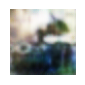

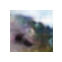

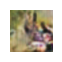

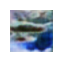

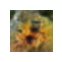

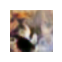

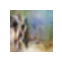

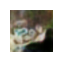

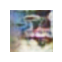

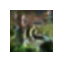

In [6]:
# Hyperparameters
noise_dim = 100
text_dim = 119
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator(noise_dim, text_dim)
discriminator = Discriminator(text_dim)

# Train models
train_wgan(generator, discriminator, dataloader, epochs, noise_dim, text_dim, device)

# Generate and save images
generate_and_save_images(generator, epochs, noise_dim, text_dim, device)

In [7]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

def evaluate_gan(generator, dataloader, noise_dim, text_dim, device, num_generated_images=None):
    """
    Evaluate GAN using FID and IS metrics.

    Args:
        generator (torch.nn.Module): Trained generator model.
        dataloader (DataLoader): DataLoader for real images.
        noise_dim (int): Dimension of noise vector.
        text_dim (int): Dimension of text embedding vector.
        device (torch.device): Device for computation.
        num_generated_images (int): Number of images to generate for IS (optional).

    Returns:
        tuple: (FID Score, IS Mean, IS Std)
    """
    # Initialize FID and IS metrics
    fid = FrechetInceptionDistance(feature=2048).to(device)
    inception_score = InceptionScore(feature=2048, splits=10).to(device)

    # Helper function to denormalize images
    def denormalize(imgs):
        return ((imgs * 0.5 + 0.5) * 255).clamp(0, 255).to(torch.uint8)

    generator.eval()

    # FID: Evaluate real images
    print("Calculating FID for real images...")
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        fid.update(denormalize(real_images), real=True)

    # FID: Evaluate generated images
    print("Generating and evaluating fake images for FID...")
    batch_size = next(iter(dataloader))[0].shape[0]
    with torch.no_grad():
        for _ in range(len(dataloader)):  # Match dataset size
            noise = torch.randn(batch_size, noise_dim).to(device)
            text = torch.randn(batch_size, text_dim).to(device)
            fake_images = generator(noise, text).to(device)
            fid.update(denormalize(fake_images), real=False)

    fid_score = fid.compute().item()
    print(f"FID Score: {fid_score}")

    # Inception Score
    if not num_generated_images:
        num_generated_images = len(dataloader) * batch_size
    print("Calculating Inception Score...")
    with torch.no_grad():
        for _ in range(num_generated_images // 64):  # Generate in batches of 64
            noise = torch.randn(64, noise_dim).to(device)
            text = torch.randn(64, text_dim).to(device)
            fake_images = generator(noise, text).to(device)
            inception_score.update(denormalize(fake_images))

    is_mean, is_std = inception_score.compute()
    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

    return fid_score, is_mean.item(), is_std.item()

# Call the evaluation function after training
fid_score, is_mean, is_std = evaluate_gan(generator, dataloader, noise_dim, text_dim, device)

# Print final results
print(f"Final FID Score: {fid_score}")
print(f"Final Inception Score: {is_mean:.2f} ± {is_std:.2f}")


/home/ldusana/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Calculating FID for real images...
Generating and evaluating fake images for FID...
FID Score: 157.34388732910156
Calculating Inception Score...
Inception Score: 1.07 ± 0.00
Final FID Score: 157.34388732910156
Final Inception Score: 1.07 ± 0.00
